In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# %matplotlib notebook
%matplotlib inline
import os
import numpy as np
import astropy.units as u

from elisa import settings, BinarySystem, Observer
from elisa.analytics import LCData, LCBinaryAnalyticsTask


# setting up a custom logging config to prevent unreasonably long log messages during fit
settings.configure(LOG_CONFIG='fit', LIMB_DARKENING_LAW='logarithmic')

/tmp/ipykernel_59898/648024061.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/home/miro/elisa_env/lib/python3.8/site-packages/elisa/conf/settings.py:394: DeprecationWarning: Variable `atlas` in configuration section `support` is not longer supported and will be removed in future version.
Use atmosphere definition as initial parameter for given celestial object
  warnings.warn("Variable `atlas` in configuration section `support` is not "


# Demo No. 14 - Atmosphere models and custom limb-darkening coefficients. 

Since version 0.6, ELISa supports custom limb-darkening (LD) coefficients and multiple atmosphere model during light curve evaluation as well as fitting procedure in `AnalyticsTask`  nodule.

## Cutom atmosphere models and limb-darkening coefficients during the LC evaluation.

Lets demonstrate the ability to set custom atmospheric parameters in the JSON used to define the BinarySystem. This is an example of a binary system that would have failed to initialize due to the effective temperature of the primary component being outside the supported range of effective temperatures:

In [2]:
system_params = {
    'system': {
        "inclination": 85,
        "period": 0.3642210,
        "argument_of_periastron": 0.0,
        "gamma": 0.0,
        "eccentricity": 0.0,
        "primary_minimum_time": 0.0,
        "phase_shift": 0.0,
        "semi_major_axis": 2.0,
        "mass_ratio": 1.3
    },
    'primary': {
        "surface_potential": 8.0,
        "synchronicity": 1.0,
        "t_eff": 55000.0,
        "atmosphere": 'bb',  # black-body model used to model emerging spectral flux instead of the default 'ck04' Castelli & Kurucz model
        "limb_darkening_coefficients": {
            'bolometric': [0.5, 0.5],
            'TESS': [0.5, 0.5]
        }   # instead of interpolation, LD coefficients are set as constant across the surface 
    },
    'secondary': {
        "surface_potential": 8.0,
        "synchronicity": 1.0,
        "t_eff": 5500.0
    }
}

Atmosphere model name can be passed inside `atmosphere` component argument. Currently, two options are available, the default Castelli & Kurucz model `ck04` or black body model `bb`. LD coefficients can be passed in `limb_darkening_coefficients` component argument and they are supplied in dict format with combination of LD coefficients defined for each desired passband + mandatory `bolometric` passband. The length of each LD argument vector is defined by LD law. In case of `linear` (`cosine`) LD law, 1 LD coefficient needs to be supplied, whereas `logarithmic` or `square_root` laws requre 2 LD coefficients.

Now we can proceed to system definition and calculation of the LC.

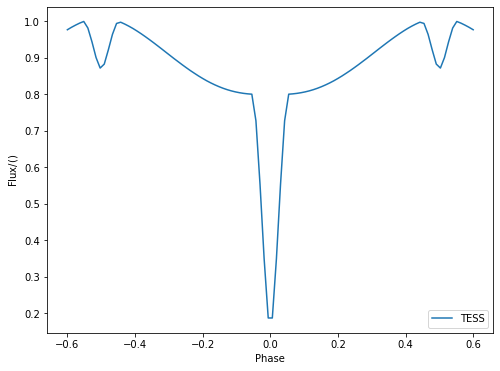

In [5]:
bs = BinarySystem.from_json(system_params)
o = Observer(passband=['TESS'], system=bs)
o.lc(phases=np.linspace(-0.6, 0.6, 100), normalize=True)
o.plot.phase_curve()

## Custom atmosphere models and limb-darkening coefficients in `AnalyticsTask` module

Custom atmosphere models and LD coefficients can be set as well within the definition of the `AnalyticsTask` instance. The fitting procedure is for the custom atmosphere models and LD coefficients is the same as described in the previous tutorials with the only difference in the definition of the `AnalyticsTask` instance:

In [ ]:
task = LCBinaryAnalyticsTask(
    data={'Kepler': kepler_data},
    method='least_squares', 
    expected_morphology='detached',
    atmosphere_models={'primary': 'bb', 'secondary': 'ck04'},
    limb_darkening_coefficients={
        "primary": {
            'bolometric': [0.5, 0.5],  
            'Kepler': [0.5, 0.5]
        }
    }
)